In [2]:

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Set your dataset path
dataset_path = 'dataset'
img_width, img_height = 64, 64  # Adjust these dimensions according to your images
batch_size = 32

# Use ImageDataGenerator to load and preprocess the data
datagen = ImageDataGenerator(rescale=1. / 255)

# Create the generator for training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',  # Use 'binary' for two classes
    color_mode='rgb',  # Change to 'rgb' if using color images
    shuffle=True,
    subset='training'
)

# Extract X_train and Y_train from the generator
num_samples = len(train_generator.filenames)
num_classes = len(train_generator.class_indices)

X_train, Y_train = [], []

for i in range(num_samples):
    x, y = train_generator.next()
    X_train.append(x)
    Y_train.append(y)

# Convert the lists to numpy arrays
X_train = np.vstack(X_train)
Y_train = np.vstack(Y_train)

# Print the shape of the arrays
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


Found 254 images belonging to 2 classes.
X_train shape: (8066, 64, 64, 3)
Y_train shape: (8066, 2)


In [3]:
x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))


In [4]:
import keras
from keras import layers
import numpy as np
original_dim = 64 * 64 *3
intermediate_dim = 64
latent_dim = 10

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)

z_log_sigma = layers.Dense(latent_dim)(h)
print(z_mean.shape)
 
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')
encoder.summary()

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


(None, 10)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12288)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           786496      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 10)           650         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 10)           650         ['dense[0][0]']                  
                                                                                 

In [5]:
vae.compile(optimizer='Adam')

In [6]:

vae.fit(x_train, x_train,
        epochs=50,
        batch_size=32)

x_decoded = vae.predict(x_train)

Epoch 1/50
253/253 [==============================] - 4s 15ms/step - loss: 8207.0674
Epoch 2/50
253/253 [==============================] - 3s 13ms/step - loss: 8040.1797
Epoch 3/50
253/253 [==============================] - 3s 14ms/step - loss: 7981.4468
Epoch 4/50
253/253 [==============================] - 3s 14ms/step - loss: 7976.9824
Epoch 5/50
253/253 [==============================] - 4s 14ms/step - loss: 7972.0581
Epoch 6/50
253/253 [==============================] - 4s 14ms/step - loss: 7970.9629
Epoch 7/50
253/253 [==============================] - 3s 14ms/step - loss: 7969.2847
Epoch 8/50
253/253 [==============================] - 3s 14ms/step - loss: 7966.2305
Epoch 9/50
253/253 [==============================] - 3s 14ms/step - loss: 7963.5527
Epoch 10/50
253/253 [==============================] - 3s 14ms/step - loss: 7962.8237
Epoch 11/50
253/253 [==============================] - 3s 14ms/step - loss: 7961.0664
Epoch 12/50
253/253 [==============================] - 4s 14ms/

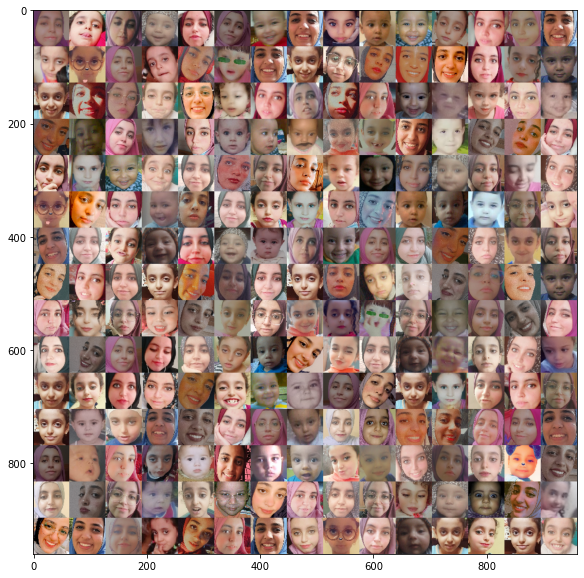

225


In [7]:
import numpy as np
import matplotlib.pyplot as plt


# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 64  # updated digit size
channels = 3  # number of channels in the image
figure = np.zeros((digit_size * n, digit_size * n, channels))  # Updated dimensions for 3 channels

# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k = 0

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # x_decoded = decoder.predict(z_sample)
        
        # Assuming x_train contains your images
        digit = x_train[k].reshape(digit_size, digit_size, channels)
        k = k + 1
        
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size, :] = digit  # Updated assignment

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
print(k)


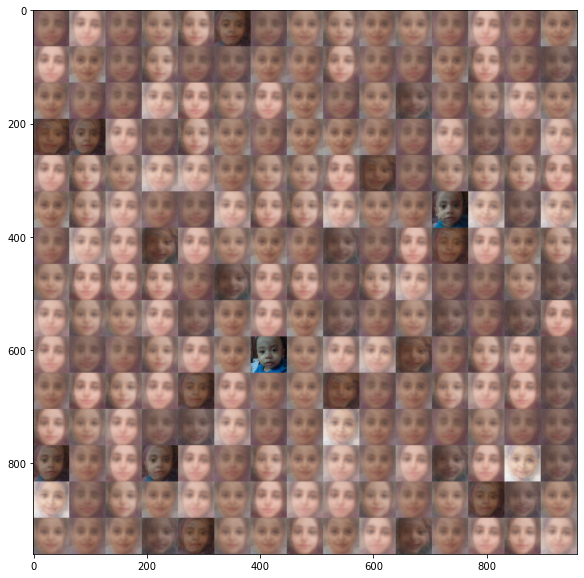

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_decoded is a 64x64x3 array
n = 15  # figure with 15x15 digits
digit_size = 64  # Update digit size to 64
figure = np.zeros((digit_size * n, digit_size * n, 3))  # Update figure dimensions

# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k = 0

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # Assuming x_decoded is a 64x64x3 array
        digit = x_decoded[k].reshape(digit_size, digit_size,channels)

        k = k + 1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


Found 254 images belonging to 2 classes.
X_train shape: (8066, 64, 64, 3)
Y_train shape: (8066, 2)
Epoch 1/50
253/253 [==============================] - 8s 30ms/step - loss: 257.3316 - lr: 9.5000e-04
Epoch 2/50
253/253 [==============================] - 8s 31ms/step - loss: 192.6426 - lr: 9.0250e-04
Epoch 3/50
253/253 [==============================] - 7s 29ms/step - loss: 175.1330 - lr: 8.5737e-04
Epoch 4/50
253/253 [==============================] - 8s 31ms/step - loss: 164.1242 - lr: 8.1451e-04
Epoch 5/50
253/253 [==============================] - 8s 30ms/step - loss: 158.1905 - lr: 7.7378e-04
Epoch 6/50
253/253 [==============================] - 8s 32ms/step - loss: 153.1909 - lr: 7.3509e-04
Epoch 7/50
253/253 [==============================] - 7s 29ms/step - loss: 148.2489 - lr: 6.9834e-04
Epoch 8/50
253/253 [==============================] - 8s 31ms/step - loss: 144.1475 - lr: 6.6342e-04
Epoch 9/50
253/253 [==============================] - 8s 32ms/step - loss: 139.5543 - lr: 6.3

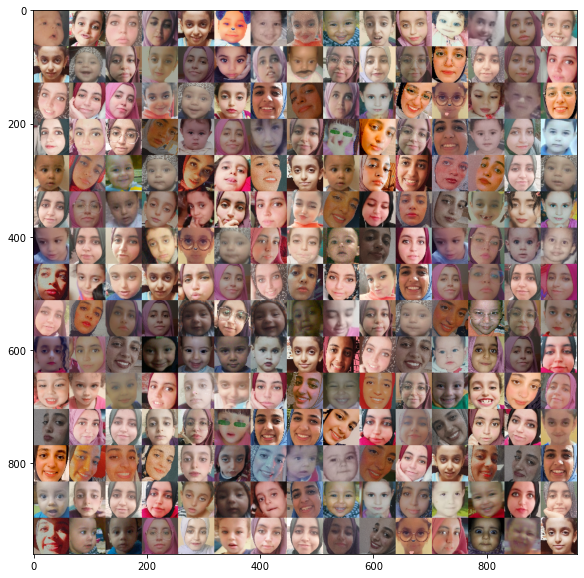

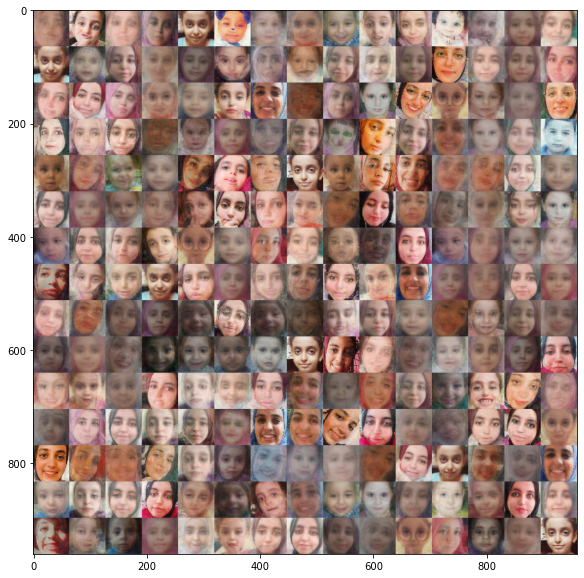

In [10]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import layers
from keras import backend as K
import matplotlib.pyplot as plt

# Set your dataset path
dataset_path = 'dataset'
img_width, img_height = 64, 64
batch_size = 32

# Use ImageDataGenerator to load and preprocess the data
datagen = ImageDataGenerator(rescale=1. / 255)

# Create the generator for training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset='training'
)

# Extract X_train and Y_train from the generator
num_samples = len(train_generator.filenames)
num_classes = len(train_generator.class_indices)

X_train, Y_train = [], []

for i in range(num_samples):
    x, y = train_generator.next()
    X_train.append(x)
    Y_train.append(y)

# Convert the lists to numpy arrays
X_train = np.vstack(X_train)
Y_train = np.vstack(Y_train)

# Print the shape of the arrays
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))

original_dim = 64 * 64 * 3
intermediate_dim = 256
latent_dim = 20

inputs = layers.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
h = layers.BatchNormalization()(h)
h = layers.Dense(128, activation='relu')(h)
h = layers.Dropout(0.5)(h)
z_mean = layers.Dense(latent_dim)(h)

z_log_sigma = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
optimizer = Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer)

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    return lr * 0.95

lr_callback = LearningRateScheduler(lr_scheduler)

vae.fit(x_train, x_train,
        epochs=50,
        batch_size=32,
        callbacks=[lr_callback])

x_decoded = vae.predict(x_train)

# Display a 2D manifold of the digits
n = 15
digit_size = 64
channels = 3
figure = np.zeros((digit_size * n, digit_size * n, channels))

grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k = 0

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        digit = x_train[k].reshape(digit_size, digit_size, channels)
        k = k + 1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size, :] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Plot decoded images
n = 15
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n, 3))
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k = 0

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        digit = x_decoded[k].reshape(digit_size, digit_size, channels)
        k = k + 1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


***CVAE

In [11]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import layers
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from keras.utils import to_categorical


# Set your dataset path
dataset_path = 'dataset'
img_width, img_height = 64, 64
batch_size = 32
num_classes = 2  # Set the number of classes in your dataset

# Use ImageDataGenerator to load and preprocess the data
datagen = ImageDataGenerator(rescale=1. / 255)

# Create the generator for training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset='training'
)

# Extract X_train and Y_train from the generator
num_samples = len(train_generator.filenames)

X_train, Y_train = [], []

for i in range(num_samples):
    x, y = train_generator.next()
    X_train.append(x)
    Y_train.append(y)

# Convert the lists to numpy arrays
X_train = np.vstack(X_train)
Y_train = np.argmax(np.vstack(Y_train), axis=1)  # Convert one-hot to class labels

# Print the shape of the arrays
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))

original_dim = 64 * 64 * 3
intermediate_dim = 256
latent_dim = 20

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy
import numpy as np

# Function to sample from the latent space using the reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder network
inputs = Input(shape=(original_dim,))
class_labels = Input(shape=(num_classes,))  # Input for class labels

x = layers.concatenate([inputs, class_labels])  # Concatenate input and class labels

x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

z_mean = Dense(64)(x)
z_log_var = Dense(64)(x)

# Use the sampling function to get the latent space sample
z = Lambda(sampling, output_shape=(64,))([z_mean, z_log_var])

# Decoder network
decoder_h = Dense(128, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Define the CVAE model
cvae = Model([inputs, class_labels], x_decoded_mean)

# Define the loss function for CVAE
xent_loss = original_dim * binary_crossentropy(inputs, x_decoded_mean)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
cvae_loss = K.mean(xent_loss + kl_loss)

cvae.add_loss(cvae_loss)
cvae.compile(optimizer='adam')

# Training the CVAE
cvae.fit([x_train, to_categorical(Y_train)], epochs=40, batch_size=batch_size)



Found 254 images belonging to 2 classes.
X_train shape: (8066, 64, 64, 3)
Y_train shape: (8066,)
Epoch 1/40
253/253 [==============================] - 6s 24ms/step - loss: 8070.2046
Epoch 2/40
253/253 [==============================] - 7s 27ms/step - loss: 7778.0215
Epoch 3/40
253/253 [==============================] - 8s 31ms/step - loss: 7690.7065
Epoch 4/40
253/253 [==============================] - 8s 30ms/step - loss: 7636.7417
Epoch 5/40
253/253 [==============================] - 8s 31ms/step - loss: 7597.2524
Epoch 6/40
253/253 [==============================] - 8s 32ms/step - loss: 7573.9531
Epoch 7/40
253/253 [==============================] - 8s 32ms/step - loss: 7551.4399
Epoch 8/40
253/253 [==============================] - 8s 32ms/step - loss: 7530.8613
Epoch 9/40
253/253 [==============================] - 8s 32ms/step - loss: 7523.2432
Epoch 10/40
253/253 [==============================] - 8s 32ms/step - loss: 7504.3345
Epoch 11/40
253/253 [==============================]

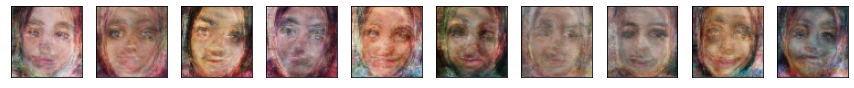

In [23]:
def plot_generated_samples(n=10):
    # Generate random latent space vectors
    z_sample = np.random.normal(size=(n, 64))
    
    # Generate samples based on random latent vectors and class labels
    generated_samples = decoder_mean(decoder_h(z_sample)).numpy()  # Convert to NumPy array
    
    # Reshape generated samples to images
    generated_samples = generated_samples.reshape((n, 64, 64, 3))

    # Plot the generated samples
    plt.figure(figsize=(15, 10))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_samples[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Plot generated samples
plot_generated_samples()


1/1 [==============================] - 0s 16ms/step


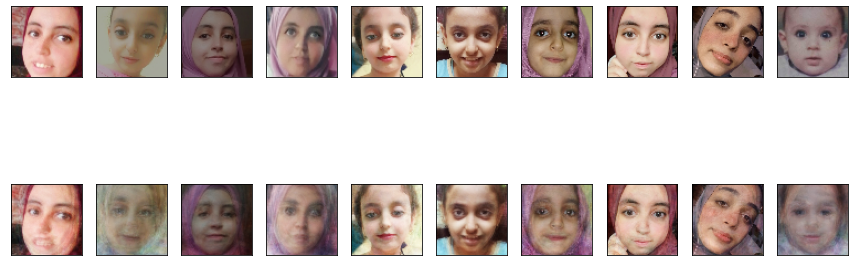

In [24]:


# Visualize reconstructed samples
def plot_reconstructed_samples(n=10):
    # Select random samples from the training set
    indices = np.random.randint(0, len(x_train), n)
    x_samples = x_train[indices]
    y_samples = Y_train[indices]
    
    # Reconstruct samples
    reconstructed_samples = cvae.predict([x_samples, to_categorical(y_samples)])
    
    # Reshape samples to images
    x_samples = x_samples.reshape((n, 64, 64, 3))
    reconstructed_samples = reconstructed_samples.reshape((n, 64, 64, 3))

    # Plot the original and reconstructed samples
    plt.figure(figsize=(15, 6))
    for i in range(n):
        # Original samples
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_samples[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Reconstructed samples
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed_samples[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


# Plot reconstructed samples
plot_reconstructed_samples()


1/1 [==============================] - 0s 16ms/step


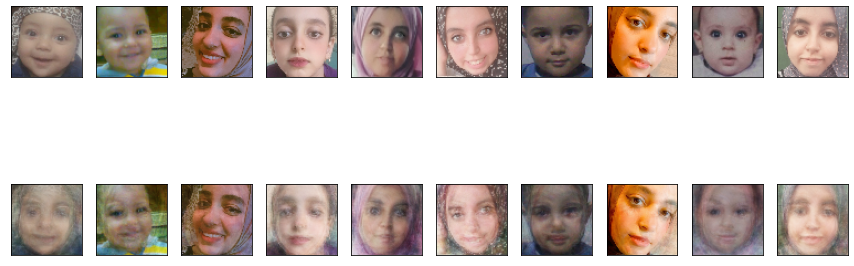

In [30]:


# Visualize reconstructed samples
def plot_reconstructed_samples(n=10):
    # Select random samples from the training set
    indices = np.random.randint(0, len(x_train), n)
    x_samples = x_train[indices]
    y_samples = Y_train[indices]
    
    # Reconstruct samples
    reconstructed_samples = cvae.predict([x_samples, to_categorical(y_samples)])
    
    # Reshape samples to images
    x_samples = x_samples.reshape((n, 64, 64, 3))
    reconstructed_samples = reconstructed_samples.reshape((n, 64, 64, 3))

    # Plot the original and reconstructed samples
    plt.figure(figsize=(15, 6))
    for i in range(n):
        # Original samples
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_samples[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Reconstructed samples
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed_samples[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


# Plot reconstructed samples
plot_reconstructed_samples()


In [38]:
from keras.layers import Input, Dense, Lambda, Concatenate, Flatten, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.optimizers import Adam

# Set your dataset path
dataset_path = 'dataset'
img_width, img_height = 64, 64
batch_size = 32
num_classes = 2  # Set the number of classes in your dataset


# Use ImageDataGenerator to load and preprocess the data
datagen = ImageDataGenerator(rescale=1. / 255)

# Create the generator for training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset='training'
)

# Extract X_train and Y_train from the generator
num_samples = len(train_generator.filenames)

X_train, Y_train = [], []

for i in range(num_samples):
    x, y = train_generator.next()
    X_train.append(x)
    Y_train.append(y)

# Convert the lists to numpy arrays
X_train = np.vstack(X_train)
Y_train = np.argmax(np.vstack(Y_train), axis=1)  # Convert one-hot to class labels

# Print the shape of the arrays
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))

original_dim = img_width * img_height * 3
intermediate_dim = 512  # Increase complexity
latent_dim = 50  # Increase complexity

# Encoder network
inputs = Input(shape=(original_dim,))
class_labels = Input(shape=(num_classes,))

x = Concatenate()([inputs, class_labels])
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Use the sampling function to get the latent space sample
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder network
decoder_h = Dense(128, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# Define the CVAE model
cvae = Model([inputs, class_labels], x_decoded_mean)

# Define the loss function for CVAE
xent_loss = original_dim * binary_crossentropy(inputs, x_decoded_mean)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
cvae_loss = K.mean(xent_loss + kl_loss)

cvae.add_loss(cvae_loss)
cvae.compile(optimizer=Adam(lr=0.0001))  # Adjust learning rate if needed

# Training the CVAE
cvae.fit([x_train, to_categorical(Y_train)], epochs=40, batch_size=batch_size)


Found 254 images belonging to 2 classes.
X_train shape: (8066, 64, 64, 3)
Y_train shape: (8066,)
Epoch 1/40
253/253 [==============================] - 10s 36ms/step - loss: 8253.3545
Epoch 2/40
253/253 [==============================] - 9s 35ms/step - loss: 7977.8867
Epoch 3/40
253/253 [==============================] - 9s 35ms/step - loss: 7838.7827
Epoch 4/40
253/253 [==============================] - 9s 34ms/step - loss: 7772.2744
Epoch 5/40
253/253 [==============================] - 9s 34ms/step - loss: 7727.1704
Epoch 6/40
253/253 [==============================] - 9s 34ms/step - loss: 7705.0493
Epoch 7/40
253/253 [==============================] - 8s 33ms/step - loss: 7684.8677
Epoch 8/40
253/253 [==============================] - 9s 36ms/step - loss: 7661.4829
Epoch 9/40
253/253 [==============================] - 9s 34ms/step - loss: 7647.3623
Epoch 10/40
253/253 [==============================] - 10s 38ms/step - loss: 7633.5664
Epoch 11/40
253/253 [=============================

1/1 [==============================] - 0s 18ms/step


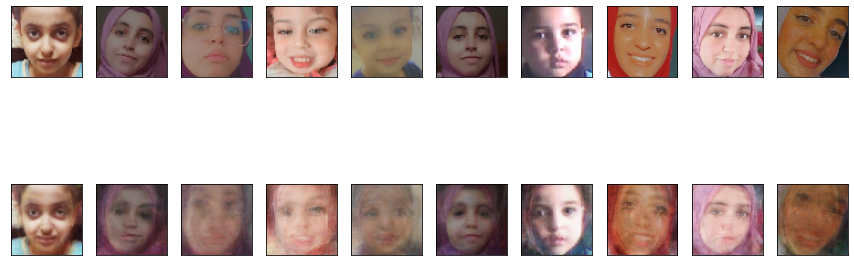

In [40]:
# Visualize reconstructed samples
def plot_reconstructed_samples(n=10):
    # Select random samples from the training set
    indices = np.random.randint(0, len(x_train), n)
    x_samples = x_train[indices]
    y_samples = Y_train[indices]
    
    # Reconstruct samples
    reconstructed_samples = cvae.predict([x_samples, to_categorical(y_samples)])
    
    # Reshape samples to images
    x_samples = x_samples.reshape((n, 64, 64, 3))
    reconstructed_samples = reconstructed_samples.reshape((n, 64, 64, 3))

    # Plot the original and reconstructed samples
    plt.figure(figsize=(15, 6))
    for i in range(n):
        # Original samples
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_samples[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Reconstructed samples
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed_samples[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_reconstructed_samples()


253/253 [==============================] - 2s 6ms/step


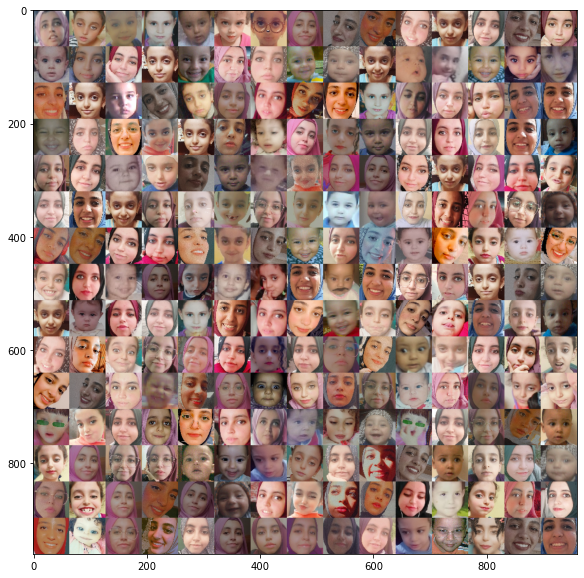

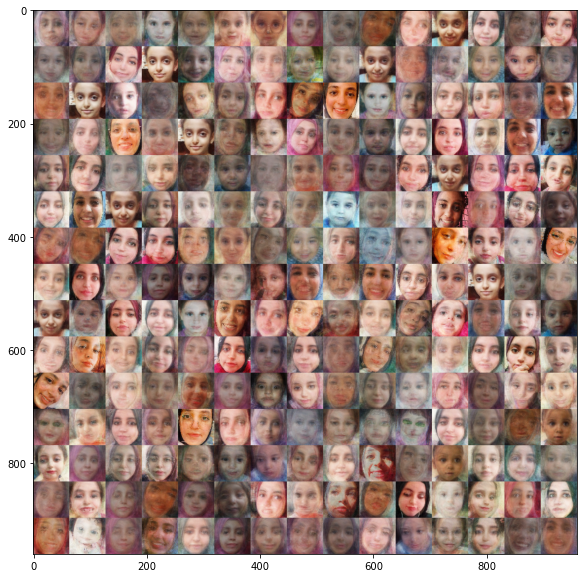

In [41]:
x_decoded= cvae.predict([x_train, to_categorical(Y_train)])
# Display a 2D manifold of the digits
n = 15
digit_size = 64
channels = 3
figure = np.zeros((digit_size * n, digit_size * n, channels))

grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k = 0

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        digit = x_train[k].reshape(digit_size, digit_size, channels)
        k = k + 1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size, :] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Plot decoded images
n = 15
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n, 3))
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k = 0

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        digit = x_decoded[k].reshape(digit_size, digit_size, channels)
        k = k + 1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [42]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import layers
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D
from keras.losses import binary_crossentropy
from keras.utils import to_categorical

# Set your dataset path
dataset_path = 'dataset'
img_width, img_height = 64, 64
batch_size = 32
num_classes = 2  # Set the number of classes in your dataset

# Use ImageDataGenerator to load and preprocess the data
datagen = ImageDataGenerator(rescale=1. / 255)

# Create the generator for training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset='training'
)

# Extract X_train and Y_train from the generator
num_samples = len(train_generator.filenames)

X_train, Y_train = [], []

for i in range(num_samples):
    x, y = train_generator.next()
    X_train.append(x)
    Y_train.append(y)

# Convert the lists to numpy arrays
X_train = np.vstack(X_train)
Y_train = np.argmax(np.vstack(Y_train), axis=1)  # Convert one-hot to class labels

# Print the shape of the arrays
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

x_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))

original_dim = 64 * 64 * 3
intermediate_dim = 256
latent_dim = 50  # Increased latent space dimension

# Function to sample from the latent space using the reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder network with more layers and dropout
inputs = Input(shape=(original_dim,))
class_labels = Input(shape=(num_classes,))  # Input for class labels

x = layers.concatenate([inputs, class_labels])  # Concatenate input and class labels

x = Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
# ... Add more layers if needed

z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Use the sampling function to get the latent space sample
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder network with convolutional layers
decoder_h = Dense(128, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')

h_decoded = decoder_h(z)
h_decoded = Dense(64, activation='relu')(h_decoded)
# ... Add more layers if needed
x_decoded_mean = decoder_mean(h_decoded)

# Define the CVAE model
cvae = Model([inputs, class_labels], x_decoded_mean)

# Define the loss function for CVAE
xent_loss = original_dim * binary_crossentropy(inputs, x_decoded_mean)
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
cvae_loss = K.mean(xent_loss + kl_loss)

cvae.add_loss(cvae_loss)
cvae.compile(optimizer=Adam(lr=0.001))

# Training the CVAE
cvae.fit([x_train, to_categorical(Y_train)], epochs=40, batch_size=64)


Found 254 images belonging to 2 classes.
X_train shape: (8066, 64, 64, 3)
Y_train shape: (8066,)
Epoch 1/40
127/127 [==============================] - 5s 31ms/step - loss: 8357.3154
Epoch 2/40
127/127 [==============================] - 3s 27ms/step - loss: 8238.6123
Epoch 3/40
127/127 [==============================] - 4s 30ms/step - loss: 8214.4268
Epoch 4/40
127/127 [==============================] - 4s 31ms/step - loss: 8179.0967
Epoch 5/40
127/127 [==============================] - 4s 28ms/step - loss: 8226.7090
Epoch 6/40
127/127 [==============================] - 4s 31ms/step - loss: 8209.7529
Epoch 7/40
127/127 [==============================] - 4s 30ms/step - loss: 8209.4268
Epoch 8/40
127/127 [==============================] - 4s 31ms/step - loss: 8220.0928
Epoch 9/40
127/127 [==============================] - 4s 29ms/step - loss: 8193.1641
Epoch 10/40
127/127 [==============================] - 4s 34ms/step - loss: 8174.3369
Epoch 11/40
127/127 [==============================]

1/1 [==============================] - 0s 15ms/step


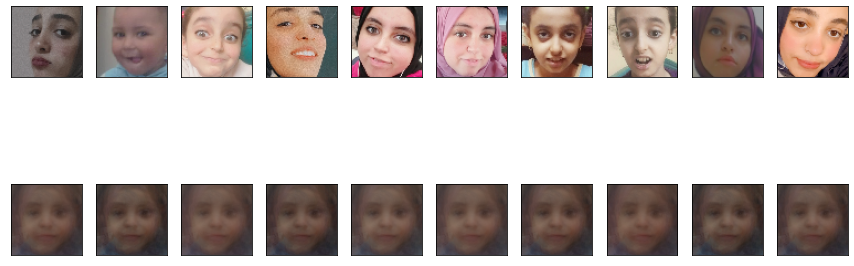

In [47]:
# Visualize reconstructed samples
def plot_reconstructed_samples(n=10):
    # Select random samples from the training set
    indices = np.random.randint(0, len(x_train), n)
    x_samples = x_train[indices]
    y_samples = Y_train[indices]
    
    # Reconstruct samples
    reconstructed_samples = cvae.predict([x_samples, to_categorical(y_samples)])
    
    # Reshape samples to images
    x_samples = x_samples.reshape((n, 64, 64, 3))
    reconstructed_samples = reconstructed_samples.reshape((n, 64, 64, 3))

    # Plot the original and reconstructed samples
    plt.figure(figsize=(15, 6))
    for i in range(n):
        # Original samples
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_samples[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # Reconstructed samples
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed_samples[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_reconstructed_samples()


253/253 [==============================] - 1s 4ms/step


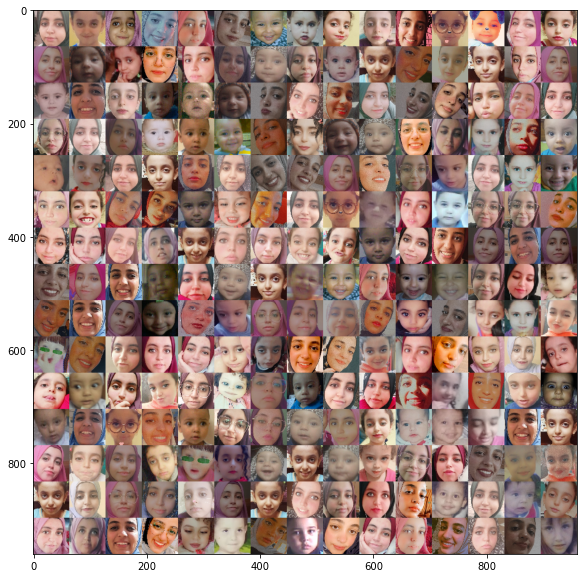

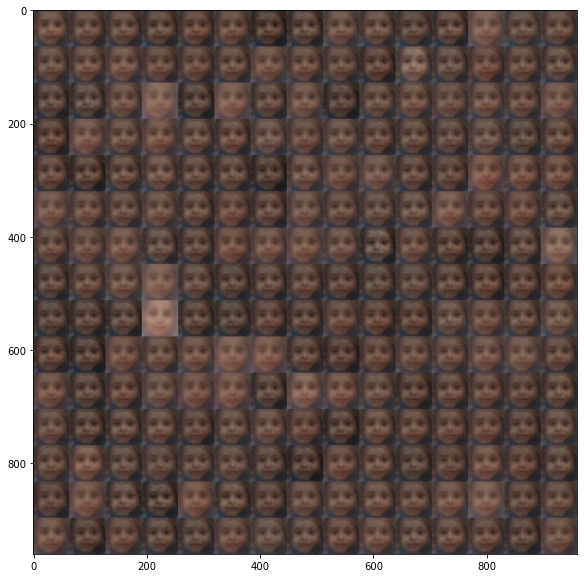

In [48]:
x_decoded= cvae.predict([x_train, to_categorical(Y_train)])
# Display a 2D manifold of the digits
n = 15
digit_size = 64
channels = 3
figure = np.zeros((digit_size * n, digit_size * n, channels))

grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k = 0

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        digit = x_train[k].reshape(digit_size, digit_size, channels)
        k = k + 1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size, :] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Plot decoded images
n = 15
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n, 3))
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
k = 0

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        digit = x_decoded[k].reshape(digit_size, digit_size, channels)
        k = k + 1
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()